In [1]:
# nltk.download('stopwords')

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
# Gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from nltk.corpus import stopwords
from nltk import Tree

stop_words = stopwords.words('english')

In [6]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [7]:
df = pd.read_csv("usnewspaper_china.csv", header=None,)

In [8]:
data = df[0].dropna().tolist()

In [9]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

In [11]:
# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def remove_stopwords_mult(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

## Bigrams and Trigrams

In [14]:
bigram = Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [15]:
# Remove Stop Words
data_words_nostops_2 = remove_stopwords_mult(data_words)

In [16]:
data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_words_nostops_2]

In [17]:
data_with_phrases[1][:10]

['cookie_preferences_cookie_list',
 'cookie_list_cookie',
 'small_piece',
 'data',
 'text_file',
 'website',
 'visited',
 'user_asks',
 'browser',
 'store']

In [18]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [19]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_with_phrases, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [20]:
data_lemmatized[2][:10]

['image',
 'make',
 'video',
 'chinese',
 'foreign',
 'gesture',
 'speak',
 'medium',
 'affair']

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#id2word.filter_extremes(no_below=20, no_above=0.5) # brings down unique tokens from 80 thousand to 12

# Create Corpus
texts = data_lemmatized#data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [22]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [23]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=25, 
                random_state=100,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)

In [24]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 46119
Number of documents: 10000


In [25]:
# Check the type of the numbers in the LDA topics
for topic in lda_model.print_topics():
    for word, prob in lda_model.show_topic(topic[0]):
        if isinstance(prob, complex):
            print(f"Complex number found in topic {topic[0]} for word '{word}'")

In [26]:
# Print the Keyword
#print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [27]:
lda_model.print_topics()

[(13,
  '0.067*"millone" + 0.027*"posible" + 0.026*"exportacion" + 0.026*"en" + 0.023*"restriccione" + 0.021*"gross" + 0.021*"dolare" + 0.018*"preocupacion" + 0.017*"entre" + 0.012*"comunicacion"'),
 (14,
  '0.113*"integrate" + 0.056*"papua" + 0.046*"farm" + 0.029*"northeast" + 0.007*"green_light" + 0.004*"nexus" + 0.000*"republic" + 0.000*"guinea" + 0.000*"congo" + 0.000*"sao_tome"'),
 (24,
  '0.264*"die" + 0.091*"und" + 0.031*"fur" + 0.031*"m" + 0.028*"sind" + 0.025*"auch" + 0.018*"haben" + 0.017*"mit" + 0.016*"hat" + 0.015*"der"'),
 (11,
  '0.336*"apple" + 0.059*"code" + 0.022*"new" + 0.020*"device" + 0.018*"new_york" + 0.018*"state" + 0.018*"island" + 0.014*"macdailynew" + 0.011*"shopping" + 0.009*"tech"'),
 (18,
  '0.131*"que" + 0.042*"por" + 0.034*"tomb" + 0.033*"archaeologist" + 0.028*"social_science" + 0.025*"segun" + 0.023*"estadounidense" + 0.022*"archaeology" + 0.020*"este" + 0.019*"para"'),
 (9,
  '0.070*"debt" + 0.051*"loan" + 0.042*"bank" + 0.039*"country" + 0.038*"dollar

In [28]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [29]:
try:
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
except Exception as e:
    print(f"Error preparing LDA visualization: {e}")

In [30]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.203028 -0.021245       1        1  16.771016
16     0.205033  0.006388       2        1  12.318784
8      0.189198  0.161587       3        1  11.792603
17     0.134028  0.009579       4        1   6.840028
21     0.171827  0.018515       5        1   6.649356
15     0.211331 -0.138095       6        1   6.538611
0      0.186160 -0.053886       7        1   5.908648
19     0.135875  0.009692       8        1   5.619607
4      0.141425 -0.178729       9        1   4.078846
20     0.127880 -0.210344      10        1   3.614008
23     0.117952 -0.153102      11        1   2.998836
1      0.022818  0.195410      12        1   2.815006
5      0.041801  0.265411      13        1   2.550569
10     0.046220  0.275623      14        1   2.007544
6     -0.047615  0.047574      15        1   1.767785
2      0.035879  0.005145      16        1   1.627399
22    -0.065895 -0.018054      17        1   1.304204
3     -0.060878 -0.127345      18        1   1.259159
18    -0.208085 -0.018147      19        1   1.199138
9     -0.057517  0.055451      20        1   1.014922
24    -0.276128 -0.021490      21        1   0.592239
12    -0.271958 -0.034327      22        1   0.448993
11    -0.306212 -0.014851      23        1   0.146250
13    -0.337551 -0.030353      24        1   0.096389
14    -0.338616 -0.030405      25        1   0.040062, topic_info=                            Term          Freq         Total Category  \
288                          say  50265.000000  50265.000000  Default   
1284                     company  10335.000000  10335.000000  Default   
80                       country  15343.000000  15343.000000  Default   
216                     military  10306.000000  10306.000000  Default   
452                          die   4022.000000   4022.000000  Default   
...                          ...           ...           ...      ...   
7926           lebanese_republic      0.014606      1.172292  Topic25   
7927             mcdonald_island      0.014606      1.172292  Topic25   
7928  micronesia_federated_state      0.014606      1.172292  Topic25   
7078                     kingdom      0.014606      1.172293  Topic25   
7915                 cook_island      0.014606      1.172293  Topic25   

      logprob  loglift  
288   30.0000  30.0000  
1284  29.0000  29.0000  
80    28.0000  28.0000  
216   27.0000  27.0000  
452   26.0000  26.0000  
...       ...      ...  
7926 -11.0347   3.4372  
7927 -11.0347   3.4372  
7928 -11.0347   3.4372  
7078 -11.0347   3.4372  
7915 -11.0347   3.4372  

[1485 rows x 6 columns], token_table=      Topic      Freq                     Term
term                                          
4587     11  0.986307                   absurd
4170      4  0.995649                    abuse
4324      7  0.981822                 academia
4925      1  0.994079                 academic
2168      1  0.092890                   accept
...     ...       ...                      ...
934       9  0.994828                zelenskyy
1273      2  0.229788                     zone
1273     10  0.617791                     zone
1273     11  0.150681                     zone
3121     18  0.991196  zq_follow_yahoo_finance

[3410 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 17, 9, 18, 22, 16, 1, 20, 5, 21, 24, 2, 6, 11, 7, 3, 23, 4, 19, 10, 25, 13, 12, 14, 15])

In [31]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -12.375325647851191


In [32]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5204142868634661


## Testing different number of topics for LDA

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics, 
                random_state=100,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=35, step=5)

10
15
20
25
30


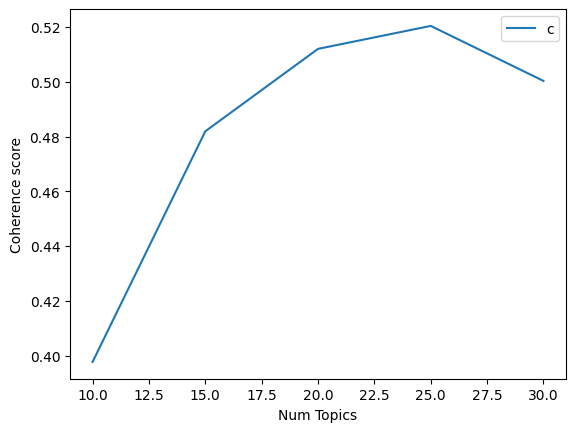

In [35]:
limit=35; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.3977
Num Topics = 15  has Coherence Value of 0.4819
Num Topics = 20  has Coherence Value of 0.512
Num Topics = 25  has Coherence Value of 0.5204
Num Topics = 30  has Coherence Value of 0.5003


### The optimal number of topics was 25

In [37]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(13,
  '0.067*"millone" + 0.027*"posible" + 0.026*"exportacion" + 0.026*"en" + '
  '0.023*"restriccione" + 0.021*"gross" + 0.021*"dolare" + '
  '0.018*"preocupacion" + 0.017*"entre" + 0.012*"comunicacion"'),
 (14,
  '0.113*"integrate" + 0.056*"papua" + 0.046*"farm" + 0.029*"northeast" + '
  '0.007*"green_light" + 0.004*"nexus" + 0.000*"republic" + 0.000*"guinea" + '
  '0.000*"congo" + 0.000*"sao_tome"'),
 (24,
  '0.264*"die" + 0.091*"und" + 0.031*"fur" + 0.031*"m" + 0.028*"sind" + '
  '0.025*"auch" + 0.018*"haben" + 0.017*"mit" + 0.016*"hat" + 0.015*"der"'),
 (11,
  '0.336*"apple" + 0.059*"code" + 0.022*"new" + 0.020*"device" + '
  '0.018*"new_york" + 0.018*"state" + 0.018*"island" + 0.014*"macdailynew" + '
  '0.011*"shopping" + 0.009*"tech"'),
 (18,
  '0.131*"que" + 0.042*"por" + 0.034*"tomb" + 0.033*"archaeologist" + '
  '0.028*"social_science" + 0.025*"segun" + 0.023*"estadounidense" + '
  '0.022*"archaeology" + 0.020*"este" + 0.019*"para"'),
 (9,
  '0.070*"debt" + 0.051*"loan" + 0

## Finding the dominant topic in each document

In [38]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    #sent_topics_df = pd.DataFrame()
    top_list = []

    # Get main topic in each document
    for i, row in enumerate(list(ldamodel[corpus])):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percent Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                top_list.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break
    sent_topics_df = pd.DataFrame(top_list, columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [39]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,21,0.3029,"technology, new, system, power, develop, use, ...","In the new Sino-Russian defense relationship, ..."
1,1,22,0.9810,"advertisement, insider, use, cookie, website, ...",Cookie Preferences Cookie List Cookie List A c...
2,2,16,0.3360,"say, report, year, chinese, accord, last, also...","In this image made from video, Chinese Foreign..."
3,3,19,0.8039,"people, say, city, covid, year, child, new, de...",Associated Press BEIJING — Heavy flooding has ...
4,4,12,0.4662,"tiktok, climate, meet, getty_image, bytedance,...","El presidente estadounidense, Joe Biden, afirm..."
5,5,19,0.5013,"people, say, city, covid, year, child, new, de...",BEIJING — China on Saturday reported nearly 60...
6,6,8,0.6479,"year, economy, growth, market, economic, month...",Oil tankers sail along Nakhodka Bay near the p...
7,7,4,0.3017,"war, russian, military, peace, conflict, say, ...",U.S. National Security Adviser Jake Sullivan s...
8,8,13,0.4442,"millone, posible, exportacion, en, restriccion...","La secretaria del Tesoro de Estados Unidos, Ja..."
9,9,15,0.3414,"say, official, chinese, visit, united_state, t...",A Chinese fighter jet swerved in front of a U....


In [40]:
key = {}
for i in lda_model.show_topics(num_topics=25, formatted=False):
    words_per_topics = []
    topic_number = i[0]
    row = i[1]
    for j in row:
        word = j[0]
        words_per_topics.append(word)
    #sent = ' '.join(words_per_topics)
    sent = words_per_topics
    key.update({topic_number: sent})

In [41]:
key

{0: ['country',
  'economic',
  'foreign',
  'security',
  'relation',
  'tie',
  'cooperation',
  'trade',
  'leader',
  'also'],
 1: ['export',
  'import',
  'production',
  'trade',
  'standard',
  'energy',
  'thomson_reuters_trust_principle',
  'oil',
  'edit',
  'supply'],
 2: ['say',
  'find',
  'ai',
  'release',
  'researcher',
  'use',
  'accord',
  'site',
  'expert',
  'study'],
 3: ['defense',
  'military',
  'space',
  'missile',
  'weapon',
  'drone',
  'air',
  'capability',
  'launch',
  'aircraft'],
 4: ['war',
  'russian',
  'military',
  'peace',
  'conflict',
  'say',
  'sanction',
  'support',
  'nuclear',
  'invasion'],
 5: ['company',
  'chip',
  'technology',
  'firm',
  'share',
  'business',
  'investment',
  'tech',
  'stock',
  'restriction'],
 6: ['event',
  'day',
  'video',
  'game',
  'iphone',
  'mile',
  'team',
  'los_angeles',
  'first',
  'start'],
 7: ['chinese',
  'make',
  'go',
  'get',
  'government',
  'take',
  'time',
  'even',
  'many',
  

# Create tree representation

In [44]:
nlp = spacy.load("en_core_web_sm")
data_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_words]

In [45]:
df_list = []
for doc in data_phrases:
    new = ' '.join(doc)
    sents = list(nlp(new).sents)
    doc_graph = []
    for sent in sents:
        #print(sent)
        for token in sent:
            node_1 = token.text
            edge = token.dep_
            node_2 = token.head.text
            doc_graph.append([node_1, edge, node_2])
        #print("#############################")
    doc_df = pd.DataFrame(doc_graph, columns = ['node_1', 'edge', 'node_2'])
    df_list.append(doc_df)         

In [49]:
df_list[4]

,node_1,edge,node_2
0,el,compound,estadounidense
1,presidente,compound,estadounidense
2,estadounidense,advmod,que
3,joe_biden,det,afirmo
4,afirmo,nsubj,que
...,...,...,...
477,su,compound,campana
478,campana,appos,en
479,para,appos,campana
480,las_elecciones,punct,para


In [51]:
#from spacy.displacy import parse_deps
#print(parse_deps())#topic))

In [52]:
#displacy.render(topic, style='dep', jupyter=True, options={'distance':90})

In [53]:
#data_lemmatized[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

In [54]:
#def to_nltk_tree(node):
#    if node.n_lefts + node.n_rights > 0:
#        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
#    else:
#        return node.orth_
    

In [56]:
#doc = nlp(data[2])
#[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

In [ ]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))